In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import seaborn as sns
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Data transforms with more augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
#Training images
# Load datasets
trainset = torchvision.datasets.ImageFolder(root=r'C:\Users\omerf\OneDrive\Masaüstü\Learning From Data Project\classes_train', transform=transform)
testset = torchvision.datasets.ImageFolder(root=r'C:\Users\omerf\OneDrive\Masaüstü\Learning From Data Project\classes_test', transform=transform)

In [4]:
loader_train = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
loader_test = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)

In [28]:
# Define the embedding model with dropout
class EmbeddingModel(nn.Module):
    def __init__(self, base_model, embedding_size):
        super(EmbeddingModel, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Linear(base_model.fc.in_features, embedding_size)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.relu(x)
        return x

In [6]:
# Load pretrained ResNet18 and create embedding model
resnet = torchvision.models.resnet18(pretrained=True)
embedding_resnet = EmbeddingModel(resnet, embedding_size=128).to(device)

C:\Users\omerf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\omerf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
#Define contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [8]:
criterion_contrastive = ContrastiveLoss()
optimizer_contrastive = optim.Adam(embedding_resnet.parameters(), lr=0.00001)

In [9]:
# Function to create pairs
def create_pairs(images, labels, num_pairs=16):
    pairs = []
    for i in range(num_pairs):
        idx1, idx2 = torch.randint(0, len(images), (2,))
        img1, img2 = images[idx1], images[idx2]
        label = torch.tensor(int(labels[idx1] == labels[idx2]), dtype=torch.float32)
        pairs.append((img1, img2, label))
    return pairs

In [10]:
# Training loop for the contrastive loss
losses = []
num_epochs_contrastive = 30 
for epoch in range(num_epochs_contrastive):
    embedding_resnet.train()
    running_loss = 0.0
    for images, labels in loader_train:
        images, labels = images.to(device), labels.to(device)
        pairs = create_pairs(images, labels, num_pairs=16)
        for img1, img2, label in pairs:
            optimizer_contrastive.zero_grad()
            img1, img2, label = img1.unsqueeze(0).to(device), img2.unsqueeze(0).to(device), label.to(device)
            
            output1 = embedding_resnet(img1)
            output2 = embedding_resnet(img2)
            
            loss = criterion_contrastive(output1, output2, label)
            
            loss.backward()
            optimizer_contrastive.step()
            
            running_loss += loss.item()
    
    avg_loss = running_loss / len(loader_train)
    print(f"Epoch: {epoch}, Contrastive Loss: {avg_loss:.4f}")
    losses.append(avg_loss)


Epoch: 0, Contrastive Loss: 291.6667
Epoch: 1, Contrastive Loss: 174.3305
Epoch: 2, Contrastive Loss: 113.2721
Epoch: 3, Contrastive Loss: 79.4642
Epoch: 4, Contrastive Loss: 54.5166
Epoch: 5, Contrastive Loss: 39.2450
Epoch: 6, Contrastive Loss: 29.7070
Epoch: 7, Contrastive Loss: 24.4620
Epoch: 8, Contrastive Loss: 18.1444
Epoch: 9, Contrastive Loss: 16.2788
Epoch: 10, Contrastive Loss: 12.5697
Epoch: 11, Contrastive Loss: 9.7848
Epoch: 12, Contrastive Loss: 8.8462
Epoch: 13, Contrastive Loss: 6.4297
Epoch: 14, Contrastive Loss: 6.0500
Epoch: 15, Contrastive Loss: 6.2031
Epoch: 16, Contrastive Loss: 5.4429
Epoch: 17, Contrastive Loss: 5.8151
Epoch: 18, Contrastive Loss: 5.3233
Epoch: 19, Contrastive Loss: 5.4211
Epoch: 20, Contrastive Loss: 5.0312
Epoch: 21, Contrastive Loss: 4.6294
Epoch: 22, Contrastive Loss: 4.4495
Epoch: 23, Contrastive Loss: 3.8266
Epoch: 24, Contrastive Loss: 4.2769
Epoch: 25, Contrastive Loss: 4.0150
Epoch: 26, Contrastive Loss: 3.8620
Epoch: 27, Contrastive L

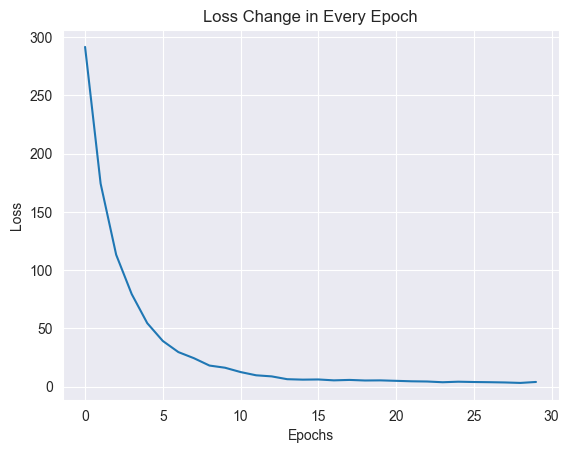

<Figure size 640x480 with 0 Axes>

In [11]:
# Plotting the loss
sns.lineplot(x=range(len(losses)), y=losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Change in Every Epoch")
plt.show()
plt.savefig("loss.png")

In [29]:
#Adding linear classifier on top of the Embedding Model
class FullModel(nn.Module):
    def __init__(self, embedding_model, num_classes):
        super(FullModel, self).__init__()
        self.embedding_model = embedding_model
        self.classifier = nn.Sequential(
            nn.Linear(in_features=128, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.embedding_model(x)
        x = self.classifier(x)
        return x

In [30]:
# Number of classes in the dataset
num_classes = len(trainset.classes)
# Create full model
full_model = FullModel(embedding_resnet, num_classes).to(device)

In [31]:
# Freezing ResNet-18 Params
for param in full_model.embedding_model.base_model.parameters():
    param.requires_grad = False
# Defining loss function and optimizer for the classifier
criterion_classifier = nn.CrossEntropyLoss()
optimizer_classifier = optim.Adam(full_model.classifier.parameters(), lr=0.001)

In [32]:
# Training loop for classifier
loss1 = []
accuracy = []
num_epochs_classifier = 10
for epoch in range(num_epochs_classifier):
    full_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader_train:
        images, labels = images.to(device), labels.to(device)
        optimizer_classifier.zero_grad()
        
        outputs = full_model(images)
        loss = criterion_classifier(outputs, labels)
                
        loss.backward()
        optimizer_classifier.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(loader_train)
    acc = 100 * correct / total
    print(f"Epoch: {epoch}, Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")
    loss1.append(avg_loss)
    accuracy.append(acc)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x512 and 128x512)

In [ ]:
# Plotting the classifier loss
sns.lineplot(x=range(len(loss1)), y=loss1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Classifier Loss Change in Every Epoch")
plt.show()

In [ ]:
# Plotting the classifier accuracy
sns.lineplot(x=range(len(accuracy)), y=accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Classifier Accuracy Change in Every Epoch")
plt.show()